# 1. Load the dataset and clean it

In [4]:
import pandas as pd
import matplotlib.pyplot as plt


df = pd.read_csv('./sales_data_sample.csv', encoding='ISO-8859-1')
# Cleaning data
df.loc[df['POSTALCODE'].isnull(), 'POSTALCODE'] = 'Unknown'
df.loc[df['TERRITORY'].isnull(), 'TERRITORY'] = 'Unknown'

# Convert 'ORDERDATE' to datetime
df['ORDERDATE'] = pd.to_datetime(df['ORDERDATE'])

# The summary of the dataset
df_info = df.info(verbose=False, memory_usage='deep')  
print(df_info)  

# The whole dataset
print("\nCleaned dataset info:")
df.info(verbose=True, memory_usage='deep')  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2823 entries, 0 to 2822
Columns: 25 entries, ORDERNUMBER to DEALSIZE
dtypes: datetime64[ns](1), float64(2), int64(7), object(15)
memory usage: 2.8 MB
None

Cleaned dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2823 entries, 0 to 2822
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   ORDERNUMBER       2823 non-null   int64         
 1   QUANTITYORDERED   2823 non-null   int64         
 2   PRICEEACH         2823 non-null   float64       
 3   ORDERLINENUMBER   2823 non-null   int64         
 4   SALES             2823 non-null   float64       
 5   ORDERDATE         2823 non-null   datetime64[ns]
 6   STATUS            2823 non-null   object        
 7   QTR_ID            2823 non-null   int64         
 8   MONTH_ID          2823 non-null   int64         
 9   YEAR_ID           2823 non-null   int64         
 10  PRODUCTLINE 

# 2. Compute: Total revenue generated & Total units sold & Average price per unit

In [5]:
# Grouping data 
product_metrics = df.groupby('PRODUCTCODE').agg(
    Total_Revenue=('SALES', 'sum'),
    Total_Units_Sold=('QUANTITYORDERED', 'sum'),
    Average_Price_Per_Unit=('PRICEEACH', 'mean'),
    Total_Orders=('ORDERNUMBER', 'nunique')
).reset_index()

# Ranking products
product_metrics['Revenue_Rank'] = product_metrics['Total_Revenue'].rank(ascending=False, method='min')
product_metrics['Units_Sold_Rank'] = product_metrics['Total_Units_Sold'].rank(ascending=False, method='min')
product_metrics['Price_Rank'] = product_metrics['Average_Price_Per_Unit'].rank(ascending=False, method='min')
product_metrics['Orders_Rank'] = product_metrics['Total_Orders'].rank(ascending=False, method='min')

# Calculate products rank and sort products 
product_metrics['Overall_Rank'] = product_metrics[['Revenue_Rank', 'Units_Sold_Rank', 'Price_Rank', 'Orders_Rank']].mean(axis=1)
product_metrics = product_metrics.sort_values(by='Overall_Rank')

pd.set_option('display.max_rows', None) 
pd.set_option('display.max_columns', None)  
print(product_metrics)

# Generate product recommendations based on top ranked products
recommendations = []

top_products = product_metrics.head(5)
recommendations.append("Focus on promoting the following top-ranked products:")
for index, row in top_products.iterrows():
    recommendations.append(f"Product Code: {row['PRODUCTCODE']}, Total Revenue: {row['Total_Revenue']:.2f}, Total Units Sold: {row['Total_Units_Sold']}, Average Price: {row['Average_Price_Per_Unit']:.2f}, Total Orders: {row['Total_Orders']}")

print("\nRecommendations:")
for rec in recommendations:
    print(rec)

pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')


    PRODUCTCODE  Total_Revenue  Total_Units_Sold  Average_Price_Per_Unit  \
39     S18_3232      288245.42              1774               99.045000   
1      S10_1949      191073.03               961              100.000000   
76     S24_3856      140626.90              1052               98.068519   
63     S24_2300      125273.43               996              100.000000   
25     S18_2238      154623.95               966               99.555556   
8      S12_1666      136692.72               972               98.657500   
50     S18_4600      123723.08              1031               98.374444   
17     S18_1129      129757.49               947               99.201111   
92     S50_1392      108779.13               979               97.006429   
9      S12_2823      140006.16               964               99.189231   
16     S18_1097      106086.56               999               94.588571   
14     S12_4473      115881.94              1024               93.390370   
5      S10_4

# 3. Compute:  Total revenue generated & Total units sold & Average price per unit

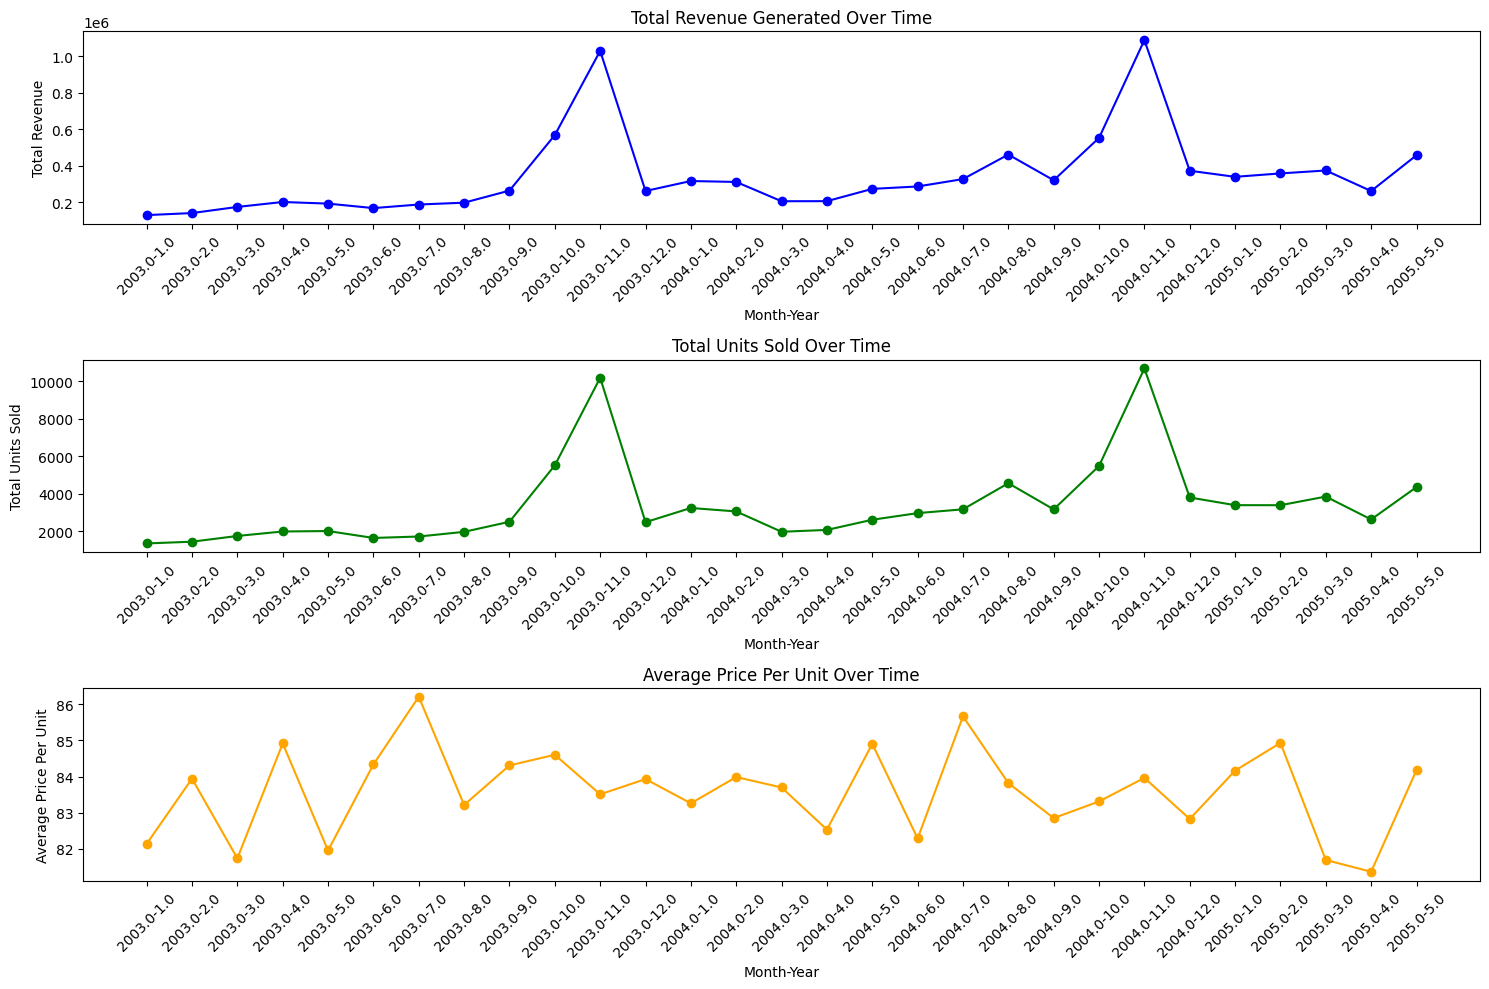

Trends in metrics:
Total Revenue: Fluctuating
Total Units Sold: Fluctuating
Average Price Per Unit: Fluctuating


In [6]:
# Extract and convert date 
df['ORDERDATE'] = pd.to_datetime(df['ORDERDATE'])
df['Year'] = df['ORDERDATE'].dt.year
df['Month'] = df['ORDERDATE'].dt.month

# Group data by Year and Month and calculate monthly_metrics
monthly_metrics = df.groupby(['Year', 'Month']).agg(
    Total_Revenue=('SALES', 'sum'),
    Total_Units_Sold=('QUANTITYORDERED', 'sum'),
    Average_Price_Per_Unit=('PRICEEACH', 'mean'),
).reset_index()
monthly_metrics['Month-Year'] = monthly_metrics.apply(lambda x: f"{x['Year']}-{x['Month']:02}", axis=1)
plt.figure(figsize=(15, 10))

# Total Revenue
plt.subplot(3, 1, 1)
plt.plot(monthly_metrics['Month-Year'], monthly_metrics['Total_Revenue'], marker='o', color='blue')
plt.title('Total Revenue Generated Over Time')
plt.xlabel('Month-Year')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45)

# Total Units Sold
plt.subplot(3, 1, 2)
plt.plot(monthly_metrics['Month-Year'], monthly_metrics['Total_Units_Sold'], marker='o', color='green')
plt.title('Total Units Sold Over Time')
plt.xlabel('Month-Year')
plt.ylabel('Total Units Sold')
plt.xticks(rotation=45)

# Average Price Per Unit
plt.subplot(3, 1, 3)
plt.plot(monthly_metrics['Month-Year'], monthly_metrics['Average_Price_Per_Unit'], marker='o', color='orange')
plt.title('Average Price Per Unit Over Time')
plt.xlabel('Month-Year')
plt.ylabel('Average Price Per Unit')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Analyze trends in the metrics
trends = {}
if monthly_metrics['Total_Revenue'].is_monotonic_increasing:
    trends['Total Revenue'] = 'Increasing'
elif monthly_metrics['Total_Revenue'].is_monotonic_decreasing:
    trends['Total Revenue'] = 'Decreasing'
else:
    trends['Total Revenue'] = 'Fluctuating'

if monthly_metrics['Total_Units_Sold'].is_monotonic_increasing:
    trends['Total Units Sold'] = 'Increasing'
elif monthly_metrics['Total_Units_Sold'].is_monotonic_decreasing:
    trends['Total Units Sold'] = 'Decreasing'
else:
    trends['Total Units Sold'] = 'Fluctuating'

if monthly_metrics['Average_Price_Per_Unit'].is_monotonic_increasing:
    trends['Average Price Per Unit'] = 'Increasing'
elif monthly_metrics['Average_Price_Per_Unit'].is_monotonic_decreasing:
    trends['Average Price Per Unit'] = 'Decreasing'
else:
    trends['Average Price Per Unit'] = 'Fluctuating'

print("Trends in metrics:")
for metric, trend in trends.items():
    print(f"{metric}: {trend}")

# Recommendations
if trends['Total Revenue'] == 'Increasing':
    print("Recommendation: Focus on maintaining marketing efforts to sustain revenue growth.")
if trends['Total Units Sold'] == 'Decreasing':
    print("Recommendation: Investigate reasons for decline in units sold and consider promotional strategies.")
if trends['Average Price Per Unit'] == 'Increasing':
    print("Recommendation: Analyze market conditions and customer feedback to justify price increases.")


# 4. Top 5 cities where the company has the highest sales

In [20]:
# Group data by city
city_sales = df.groupby('CITY').agg(
    Total_Sales=('SALES', 'sum'),
    Total_Units_Sold=('QUANTITYORDERED', 'sum'),
    Average_Price_Per_Unit=('PRICEEACH', 'mean')
).reset_index()

# Sort the city sales data
top_cities = city_sales.sort_values(by='Total_Sales', ascending=False).head(5)
print("Top 5 Cities with Highest Sales:")
print(top_cities)
remaining_cities = city_sales[~city_sales['CITY'].isin(top_cities['CITY'])]

# Function to provide specific recommendations
def specific_recommendations(remaining_cities, top_cities):
    print("\nSpecific Recommendations to Increase Sales in Other Cities:")
    for _, row in remaining_cities.iterrows():
        city = row['CITY']
        total_sales = row['Total_Sales']
        avg_price = row['Average_Price_Per_Unit']

        if total_sales < 50000:
            print(f"- In {city}, focus on increasing awareness of high-margin products. Utilize targeted digital marketing campaigns.")
        elif 50000 <= total_sales < 100000:
            print(f"- In {city}, analyze customer preferences; consider introducing loyalty programs or bundle offers to increase repeat purchases.")
        elif avg_price < 80:
            print(f"- In {city}, evaluate customer feedback on pricing; consider offering premium options to enhance perceived value.")
        else:
            print(f"- In {city}, leverage successful strategies from top cities. Identify local influencers or events to promote products.")

specific_recommendations(remaining_cities, top_cities)

Top 5 Cities with Highest Sales:
          CITY  Total_Sales  Total_Units_Sold  Average_Price_Per_Unit
34      Madrid   1082551.44             10958               82.131086
61  San Rafael    654858.06              6366               83.314944
42         NYC    560787.77              5294               85.397961
63   Singapore    288488.41              2760               83.315190
52       Paris    268944.68              2521               84.639143

Specific Recommendations to Increase Sales in Other Cities:
- In Aaarhus, leverage successful strategies from top cities. Identify local influencers or events to promote products.
- In Allentown, leverage successful strategies from top cities. Identify local influencers or events to promote products.
- In Barcelona, analyze customer preferences; consider introducing loyalty programs or bundle offers to increase repeat purchases.
- In Bergamo, evaluate customer feedback on pricing; consider offering premium options to enhance perceived value